## Download Nifty option Chain Chain data for recent available maturity

In [1]:
import requests
import pandas as pd
import time

url = 'https://www.nseindia.com/api/option-chain-indices?symbol=NIFTY'

headers = {'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/103.0.5060.53 Safari/537.36 Edg/103.0.1264.37','accept-encoding': 'gzip, deflate, br','accept-language': 'en-GB,en;q=0.9,en-US;q=0.8'}

session = requests.Session()
request = session.get(url,headers=headers)
cookies = dict(request.cookies)


def dataframe():
    response = session.get(url,headers=headers,cookies=cookies).json()
    rawdata = pd.DataFrame(response)
    rawop = pd.DataFrame(rawdata['filtered']['data']).fillna(0)
    data = []
    for i in range(0,len(rawop)):
        calloi = callcoi = cltp = putoi = putcoi = pltp = 0
        stp = rawop['strikePrice'][i]
        if(rawop['CE'][i]==0):
            calloi = callcoi = 0
        else:
            calloi = rawop['CE'][i]['openInterest']
            callcoi = rawop['CE'][i]['changeinOpenInterest']
            cltp = rawop['CE'][i]['lastPrice']
        if(rawop['PE'][i] == 0):
            putoi = putcoi = 0
        else:
            putoi = rawop['PE'][i]['openInterest']
            putcoi = rawop['PE'][i]['changeinOpenInterest']
            pltp = rawop['PE'][i]['lastPrice']
        opdata = {
            'CALL OI': calloi, 'CALL CHNG OI': callcoi, 'CALL LTP': cltp, 'STRIKE PRICE': stp,
            'PUT OI': putoi, 'PUT CHNG OI': putcoi, 'PUT LTP': pltp
        }
        
        data.append(opdata)
    optionchain = pd.DataFrame(data)
    return optionchain

In [2]:
optionchain = dataframe()

In [3]:
pd.set_option('display.max_rows', None)

In [4]:
op_chain_df = pd.DataFrame(optionchain)

In [5]:
op_chain_df = op_chain_df[op_chain_df['CALL LTP'] > 0]

### This is how Option Chain data looks like

After filtering all call option where Latest Traded Price is Not available (0 in this case)

In [6]:
op_chain_df

,CALL OI,CALL CHNG OI,CALL LTP,STRIKE PRICE,PUT OI,PUT CHNG OI,PUT LTP
6,0,0,1419.45,22100,24900,24900,0.05
9,14,6,1286.70,22250,207821,-69105,0.05
10,1,0,1344.90,22300,66616,-84728,0.05
11,6,6,1194.25,22350,22673,-9024,0.05
12,5,4,1100.05,22400,47746,595,0.05
13,3,2,1083.95,22450,27681,-6080,0.05
14,176,-197,1035.00,22500,166244,-88637,0.05
15,28,3,981.30,22550,43050,16005,0.05
16,6,3,934.45,22600,79912,-44520,0.05
17,21,16,883.40,22650,56871,16275,0.05


In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.integrate import quad
from scipy.optimize import minimize
from datetime import datetime as dt

import yfinance as yf

In [8]:
def heston_charfunc(phi, S0, v0, kapp, theta, sigma, rho, lambd, tau, r):
    #constant
    a = kappa *theta
    b = kappa+lambd
    
    #define common terms wrt phi = rho*sigma*phi_i
    rspi = rho*sigma*phi*1j
    
    # define d parameter given phi and b
    d = np.sqrt((rho*sigma*phi*1j - b)**2 + (phi*1j + phi**2) * sigma**2)
    
    # define g
    g = (b - rspi + d) / (b - rspi - d)
    
    #calculation for characteristic function
    term1 = np.exp(r*phi*1j*tau)
    term2 = S0**(phi*1j) * ((1 - g*np.exp(d*tau)) / (1-g))**(-2*a/sigma**2)
    term3 = np.exp(a*tau*(b-rspi+d)/sigma**2 + v0/sigma**2 * (b-rspi+d) * (1-np.exp(d*tau)) / (1-g*np.exp(d*tau)))
    
    return term1*term2*term3

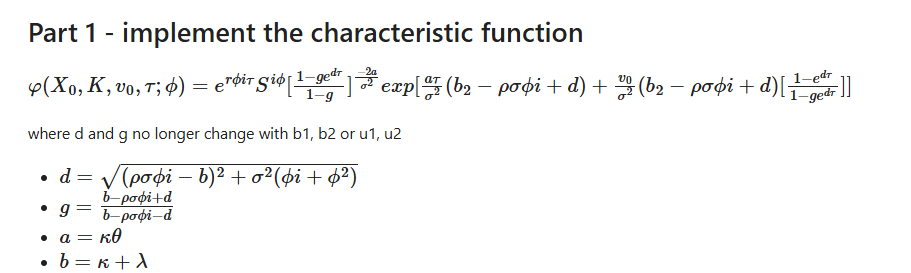

In [9]:
def heston_charfunc(phi, S0, v0, kapp, theta, sigma, rho, lambd, tau, r):
    #constant
    a = kappa *theta
    b = kappa+lambd
    
    #define common terms wrt phi = rho*sigma*phi_i
    rspi = rho*sigma*phi*1j
    
    # define d parameter given phi and b
    d = np.sqrt((rho*sigma*phi*1j - b)**2 + (phi*1j + phi**2) * sigma**2)
    
    # define g
    g = (b - rspi + d) / (b - rspi - d)
    
    #calculation for characteristic function
    term1 = np.exp(r*phi*1j*tau)
    term2 = S0**(phi*1j) * ((1 - g*np.exp(d*tau)) / (1-g))**(-2*a/sigma**2)
    term3 = np.exp(a*tau*(b-rspi+d)/sigma**2 + v0/sigma**2 * (b-rspi+d) * (1-np.exp(d*tau)) / (1-g*np.exp(d*tau)))
    
    return term1*term2*term3
    

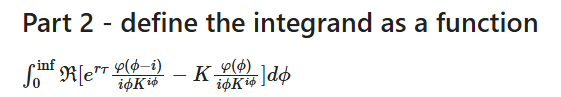

In [10]:
#solving integral part of above equation

def integrand(phi, S0, v0, kappa, theta, sigma, rho, lambd, tau, r):
    args = (S0,v0,kappa,theta,sigma,rho,lambd,tau,r)
    
    numerator = np.exp(r*tau)*heston_charfunc(phi-1j,*args) - K*heston_charfunc(phi,*args)
    denominator = 1j*phi*K**(1j*phi)
    return numerator/denominator

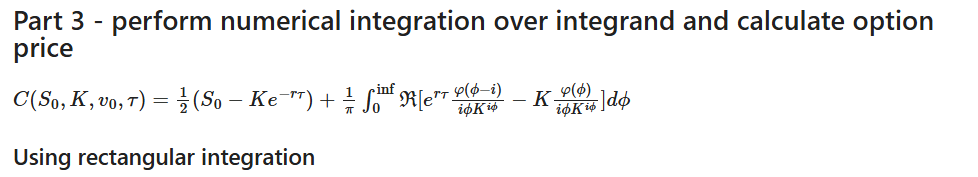


In [11]:
def heston_price_rec(S0,K,v0,kappa,theta,sigma,rho,lambd,tau,r):
    args = (S0,v0,kappa,theta,sigma,rho,lambd,tau,r)
    
    P,umax,N = 0,100,30000
    
    dphi = umax/N
    
    for i in range(1,N):
        phi = dphi * (2*i + 1)/2 #midpoint to calculate height
        numerator = np.exp(r*tau)*heston_charfunc(phi-1j, *args) - K*heston_charfunc(phi,*args)
        denominator = (1j*phi*K**(1j*phi))
        P += dphi * numerator/denominator
        
    return np.real((S0 - K*np.exp(-r*tau))/2 + P/np.pi)

In [12]:
def heston_price(S0,K,v0,kappa,theta,sigma,rho,lambd,tau,r):
    args = (S0,v0,kappa,theta,sigma,rho,lambd,tau,r)
    
    real_integral, errr = np.real(quad(integrand, 0, 100, args=args))
    
    return (S0 - K*np.exp(-r*tau))/2 + real_integral/np.pi

In [13]:
ticker = '^NSEI'

stock = yf.Ticker(ticker)
hist = stock.history(period = '3mo')
stock_price = hist['Close'].values[-1]
stock_price

23532.69921875

In [14]:
params = {"v0": {"x0": 0.1, "lbub": [1e-3,0.1]},
          "kappa": {"x0": 3, "lbub": [1e-3,5]},
          "theta": {"x0": 0.05, "lbub": [1e-3,0.1]},
          "sigma": {"x0": 0.3, "lbub": [1e-2,1]},
          "rho": {"x0": -0.8, "lbub": [-1,0]},
          "lambd": {"x0": 0.03, "lbub": [-1,1]},
          }

x0 = [param["x0"] for key, param in params.items()]
bnds = [param["lbub"] for key, param in params.items()]

In [15]:
v0 = np.arange(1e-3, 0.1, 0.05)
v0

array([0.001, 0.051])

In [16]:
kappa = np.arange(1, 5, 1.5)
kappa

array([1. , 2.5, 4. ])

In [17]:
theta = np.arange(1e-3, 0.1, 0.05)
theta

array([0.001, 0.051])

In [18]:
sigma = np.arange(1e-2, 1, 0.4)
sigma

array([0.01, 0.41, 0.81])

In [19]:
rho = np.arange(-0.8, -0.3, 0.4)
rho

array([-0.8, -0.4])

In [20]:
lambd = np.arange(-0.7, 1, 0.7)
lambd

array([-0.7,  0. ,  0.7])

In [21]:
v0_lst = []
kappa_lst = []
theta_lst = []
sigma_lst = []
rho_lst = []
lambd_lst = []
error_lst = []
strike_lst = []

In [51]:
T = 0.013698 # Time to maturity
S0 = stock_price # Current At The Money Option Strike Price
r0 = 0.066 # Risk Free Interest rate (Assumption)

In [23]:
op_chain_df = op_chain_df.loc[25:45].reset_index(drop = True) # Subsetting data (for quicker implimentation)

### Due to extensive parameter calibration, selecting best parameter based on understanding and applyting 
### brute force approach to approximate selection.

### Though brute force approach taking way longer than expected, hence aborted run in obtained 
### optimum parameter based on available result.
### Definitely not optimized solution, but idea was to impliment 
### Heston Model and calibrate to see if identified approach work. It seems worked decently.

In [31]:
# for v in v0:
#     for k in kappa:
#         for t in theta:
#             for s in sigma:
#                 for r in rho:
#                     for l in lambd:
#                         err = 0
#                         for i in range(op_chain_df.shape[0]):
#                             act_call_price = op_chain_df.loc[i,'CALL LTP']
#                             strike = op_chain_df.loc[i,'STRIKE PRICE']
#                             err = err + (act_call_price - heston_price_rec(S0,strike, v, k, t, s, r, l, T, r0)[0])
#                         v0_lst.append(v)
#                         kappa_lst.append(k)
#                         theta_lst.append(t)
#                         sigma_lst.append(s)
#                         rho_lst.append(r)
#                         lambd_lst.append(l)
#                         error_lst.append(err)

In [27]:
final_df = pd.DataFrame(zip(v0_lst, kappa_lst, theta_lst, sigma_lst, rho_lst, lambd_lst, error_lst))

In [28]:
final_df.to_csv('final_output.csv')

In [29]:
final_df.columns = ['v0','kappa','theta','sigma','rho','lambd','error']

In [30]:
final_df.sort_values('error')

,v0,kappa,theta,sigma,rho,lambd,error
108,0.051,1.0,0.001,0.01,-0.8,-0.7,-3262.108520
111,0.051,1.0,0.001,0.01,-0.4,-0.7,-3262.067458
114,0.051,1.0,0.001,0.41,-0.8,-0.7,-3258.567724
109,0.051,1.0,0.001,0.01,-0.8,0.0,-3250.725079
112,0.051,1.0,0.001,0.01,-0.4,0.0,-3250.683985
110,0.051,1.0,0.001,0.01,-0.8,0.7,-3239.389067
113,0.051,1.0,0.001,0.01,-0.4,0.7,-3239.347943
90,0.001,4.0,0.051,0.01,-0.8,-0.7,155.025291
54,0.001,2.5,0.051,0.01,-0.8,-0.7,155.025291
18,0.001,1.0,0.051,0.01,-0.8,-0.7,155.025291


In [52]:
# Selecting optimum parameter based on obtained result

v0 = 0.001
kappa = 4.0
theta = 0.051
sigma = 0.01
rho = -0.8
lambd = -0.7

In [37]:
heston_price_lst = []

In [38]:
for i in range(op_chain_df.shape[0]):
    act_call_price = op_chain_df.loc[i,'CALL LTP']
    strike = op_chain_df.loc[i,'STRIKE PRICE']
    heston_price_lst.append(heston_price_rec(S0,strike, v0, kappa, theta, sigma, rho, lambd, T, r0))

In [42]:
op_chain_df['Heston_Predicted_Price'] = heston_price_lst

In [43]:
op_chain_df.head()

,CALL OI,CALL CHNG OI,CALL LTP,STRIKE PRICE,PUT OI,PUT CHNG OI,PUT LTP,Heston_Predicted_Price
0,494,429,481.70,23050,88563,61271,0.05,529.647088
1,350,165,433.20,23100,188840,88461,0.05,467.115048
2,119,1,382.00,23150,127214,78543,0.05,405.017762
3,942,76,332.25,23200,165467,47307,0.05,344.263308
4,2137,1366,282.25,23250,132349,65209,0.05,285.763968


[]

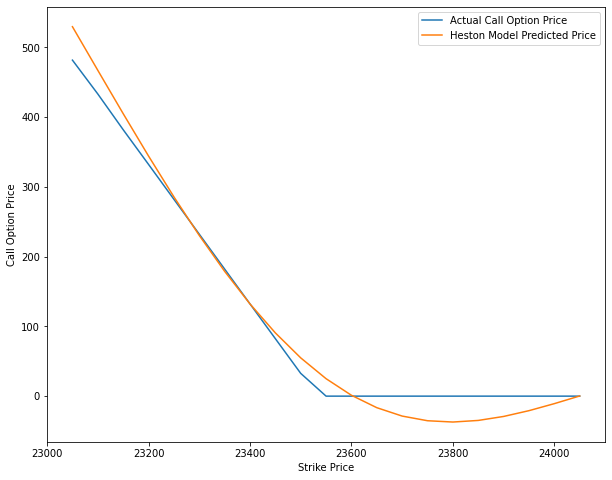

In [50]:
plt.rcParams['figure.figsize'] = [10, 8]
plt.plot(op_chain_df['STRIKE PRICE'], op_chain_df['CALL LTP'], label = 'Actual Call Option Price')
plt.plot(op_chain_df['STRIKE PRICE'], op_chain_df['Heston_Predicted_Price'], label = 'Heston Model Predicted Price')
plt.xlabel('Strike Price')
plt.ylabel('Call Option Price')
plt.legend()
plt.plot()